In [84]:
# coding: utf-8

# ### Import required libraries

import argparse

import torch, os, sys, random, gym, time
import numpy as np

from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from tqdm import tqdm
from collections import deque
from wrapper.gym_wrapper import make_atari, wrap_deepmind
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec


env_name = 'MsPacmanNoFrameskip-v4'
# model_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/logs/best/best-models/model.7257.000.tar'
# mean_image_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/logs/best/mean_pixel_image.npy'

# model_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/logs/ucb-deconv/MsPacmanNoFrameskip-v4/20180526-020540/best-models/model.9907.819.tar'
# mean_image_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/logs/ucb-deconv/MsPacmanNoFrameskip-v4/20180526-020540/mean_pixel_image.npy'

model_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/best-ucb-re-25-25/best-models/model.9950.000.tar'
mean_image_file = '/mnt/51df7bb1-bef2-4dca-ad11-aa088846cd64/github/state-aggregated-q-learning/src/models/best-ucb-re-25-25/mean_pixel_image.npy'

# ### Global Variables
lambda_reg = 0.01
n_aggregates = 20
min_val = -25
max_val = 25
agg_values = np.linspace(min_val, max_val, n_aggregates)


use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
mean_pixel_image = None


# ### Network Definition

class QNetwork(nn.Module):
    def __init__(self, input_shape, output_len, hidden_dim=256):
        super(QNetwork, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Linear(conv_out_size, hidden_dim)

        self.deconv_fc = nn.Linear(hidden_dim, conv_out_size)

        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_shape[0], kernel_size=8, stride=4)
        )

        # self.query_embed = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.key_matrix = nn.Parameter(torch.randn(output_len, n_aggregates, hidden_dim))
        self.register_buffer('agg_values', Variable(FloatTensor(agg_values).view(n_aggregates, 1)))

        self.init_weights()

    def forward(self, x):
        x = x.float() - mean_pixel_image
        x = x / 255.0
        x = x.permute(0, 3, 1, 2)   # NCHW format

        fx= self.conv(x).view(x.size()[0], -1)

        x_embed = self.fc(fx)

        # q = torch.mm(x_embed, torch.t(self.query_embed))
        q = x_embed

        att_keys = torch.matmul(self.key_matrix, torch.t(q))
        soft_keys = nn.Softmax(dim=1)(att_keys)

        att_values = soft_keys * self.agg_values
        att_values = att_values.sum(dim=1)

        # att_log_px = soft_keys.log()
        # att_entropy = -soft_keys * att_log_px
        # att_loss = torch.sum(att_entropy)

        reconstructed_img = self.deconv(self.deconv_fc(x_embed).view(x.size()[0], 64, 7, 7))
        reconstruction_loss = (reconstructed_img - x).pow(2).sum()

        # return x_embed, reconstructed_img
        # return torch.t(att_values), soft_keys, reconstruction_loss
        return torch.t(att_values), soft_keys, reconstructed_img

    def reconstruct_key(self, key_embed):
        return self.deconv(self.deconv_fc(key_embed).view(key_embed.size()[0], 64, 7, 7))

    def _get_conv_out(self, shape):
        o = self.conv(Variable(torch.zeros(1, *shape)))
        return int(np.prod(o.size()))

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
                nn.init.xavier_uniform(layer.weight.data)
                nn.init.constant(layer.bias.data, 0.0)

    def save_model_weights(self, suffix):
        # Helper function to save your model / weights.
        torch.save(self.state_dict(), suffix)

    def load_model_weights(self, model_file, strict=True):
        model_dict = torch.load(model_file)
        model_dict.pop('agg_values')

        self.load_state_dict(model_dict,strict)


# ### Helper Functions
# #### eps_greedy_action(), sample_memory()


def eps_greedy_action(curr_eps, q_values, n_action):
    if np.random.random() < curr_eps:
        action = np.random.choice(n_action)
    else:
        _, actions = torch.max(q_values, dim=0)
        action = int(actions.cpu().data.numpy())

    return action

replay_memory = []


def sample_memory(n_samples):
    return random.sample(replay_memory, n_samples)


def process_img(img):
    return np.array(img)
    # return np.array(img).reshape(4, 84, 84).astype(np.float32) / 255.0


In [85]:
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

def get_score(model, img, act):    
    q_values, _, _ = model(Variable(FloatTensor(img[None]), volatile=True))
    return q_values[0][act].cpu().data.numpy()[0]
    

def get_mask(center, size, r):
    y,x = np.ogrid[-center[0]:size[0]-center[0], -center[1]:size[1]-center[1]]
    keep = x*x + y*y <= 1
    mask = np.zeros(size) ; mask[keep] = 1
    mask = gaussian_filter(mask, sigma=r)
    return mask/mask.max()


def plot_saliency(model, state, act):
    img = process_img(state)    
    
    r = 3
    d = 3

    L = get_score(model, img, act)
    
    scores = np.zeros((int(84/d)+1,int(84/d)+1)) # saliency scores S(t,i,j)
    for i in range(0,84,d):
        for j in range(0,84,d):
            mask = get_mask(center=[i,j], size=[84,84], r=r)

            mask = np.repeat(mask[:, :, np.newaxis], 4, axis=2)       
            new_img = img * (1-mask) + gaussian_filter(img, sigma=5) * mask            
            new_img = np.clip(new_img, 0, 255.0).astype(np.uint8)            

            l = get_score(model, new_img, act)        
            scores[int(i/d),int(j/d)] = (0.5 * (L-l)**2)
    pmax = scores.max()
    scores = imresize(scores, size=[84, 84], interp='bilinear').astype(np.float32)
    scores = pmax * scores / scores.max()    
    
    saliency = scores * img[:, :, 3]
    # plt.imshow(saliency, cmap='gray')
    # plt.show()
    
    return saliency

def plot_saliency_delta(model, state, act):
    img = process_img(state)    
    
    r = 3
    d = 3

    L = get_score(model, img, act)
    
    scores = np.zeros((int(84/d)+1,int(84/d)+1)) # saliency scores S(t,i,j)
    for i in range(0,84,d):
        for j in range(0,84,d):
            mask = get_mask(center=[i,j], size=[84,84], r=r)

            mask = np.repeat(mask[:, :, np.newaxis], 4, axis=2)       
            new_img = img * (1-mask) + gaussian_filter(img, sigma=5) * mask            
            new_img = np.clip(new_img, 0, 255.0).astype(np.uint8)            

            _, soft_keys, _ = net(Variable(FloatTensor(process_img(new_img)[None]), volatile=True))        
            soft_keys = soft_keys[:, :, 0]
            act_delta = action_selector(soft_keys)
            
            scores[int(i/d),int(j/d)] = 1.0 if act_delta != act else 0            
    pmax = scores.max()
    scores = imresize(scores, size=[84, 84], interp='bilinear').astype(np.float32)
    scores = pmax * scores / scores.max()    
    
    saliency = scores * img[:, :, 3]
    # plt.imshow(saliency, cmap='gray')
    # plt.show()
    
    return saliency


def action_selector(q_distributions, lambda_exp=0.001):
    means = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1))
    variances = torch.mm(q_distributions.data, FloatTensor(agg_values).view(n_aggregates, 1).pow(2))
    variances = variances - means
    std_devs = variances.sqrt()

    optimistic_returns = means + lambda_exp * std_devs
    _, action = torch.max(optimistic_returns, dim=0)
    action = int(action)

    return action

In [88]:
env = make_atari(env_name)
env = wrap_deepmind(env, frame_stack=True, scale=False, clip_rewards=False, episode_life=False)


n_state = env.observation_space.shape
n_action = env.action_space.n

meanings = env.unwrapped.get_action_meanings()

# meanings = ['no-op', 'fire', 'up', 'down', 'up + fire', 'down + fire']

# ### Prepare for training

state = env.reset()
state_p = np.array(state).reshape(4, 84, 84).astype(np.float32) / 255.0

cumulative_rewards_tracker = []
eps_value = 0.0

net = QNetwork(state_p.shape, n_action)
if use_cuda:
    net = net.cuda()

net.load_model_weights(model_file, False)
mean_pixel_image = Variable(FloatTensor(np.load(mean_image_file)), requires_grad=False)

In [77]:
# Test mean rewards
for i in tqdm(range(100)):
    done = False
    cumulative_rewards = 0
    episode_length = 0

    while not done:
        q_values, soft_keys, _ = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
        q_values = q_values[0]
        soft_keys = soft_keys[:, :, 0]

        act = action_selector(soft_keys)        

        next_state, reward, done, _ = env.step(act)

        state = next_state
        cumulative_rewards += reward
        episode_length += 1

        if done:
            state = env.reset()
            cumulative_rewards_tracker.append(cumulative_rewards)

print('Mean: %.5f' % np.mean(cumulative_rewards_tracker))
print('Stddev: %.6f ' % np.std(cumulative_rewards_tracker))
print(cumulative_rewards_tracker)


100%|██████████| 100/100 [14:56<00:00,  8.96s/it]

Mean: 5794.90909
Stddev: 1949.631082 
[2830.0, 7220.0, 6730.0, 6730.0, 7200.0, 2830.0, 7200.0, 2830.0, 7200.0, 2830.0, 6730.0, 7200.0, 2830.0, 7200.0, 7200.0, 7200.0, 6730.0, 7200.0, 7220.0, 6730.0, 6730.0, 2830.0, 7200.0, 2830.0, 7220.0, 2830.0, 7220.0, 7200.0, 7220.0, 7200.0, 2830.0, 7220.0, 2830.0, 2830.0, 2830.0, 2830.0, 2830.0, 7200.0, 7200.0, 6730.0, 7200.0, 6730.0, 6730.0, 2830.0, 7220.0, 7200.0, 6730.0, 7220.0, 2830.0, 7220.0, 2830.0, 2830.0, 2830.0, 2830.0, 7200.0, 7220.0, 7220.0, 6730.0, 2830.0, 7200.0, 6730.0, 2830.0, 2830.0, 7200.0, 7220.0, 7200.0, 6730.0, 7200.0, 7220.0, 2830.0, 7200.0, 6730.0, 7200.0, 2830.0, 6730.0, 7200.0, 7220.0, 2830.0, 7200.0, 7220.0, 7220.0, 6730.0, 7220.0, 7200.0, 7200.0, 7220.0, 2830.0, 7220.0, 2830.0, 6730.0, 7220.0, 6730.0, 7200.0, 2830.0, 6730.0, 7200.0, 2830.0, 7220.0, 6730.0, 7220.0, 2830.0, 6730.0, 6730.0, 6730.0, 2830.0, 7200.0, 7200.0, 2830.0, 7220.0, 7200.0]


In [109]:
# Plot and test
done = False
cumulative_rewards = 0
episode_length = 0
state = env.reset()
states_visited = []

while not done:
    states_visited.append(state)
    q_values, soft_keys, _ = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
    q_values = q_values[0]
    soft_keys = soft_keys[:, :, 0]

    act = action_selector(soft_keys)        

    prob_dist = 1.0 - soft_keys.data.numpy().reshape(n_action, 20)        

    saliency = plot_saliency(net, state, act)    

    f = plt.figure(figsize=(8,8))        
    gs = gridspec.GridSpec(nrows=2, ncols=2)
    # gs.update(wspace=0.0001, hspace=0.25)

    a0 = f.add_subplot(gs[0, 0])
    a2 = f.add_subplot(gs[0, 1])
    a1 = f.add_subplot(gs[1, :])

    a0.imshow(state[:, :, 3], cmap='gray')
    a0.axis('off')

    actions = np.arange(n_action)
    aggs = agg_values

    im = a1.imshow(prob_dist, cmap='gray', interpolation='nearest')

    # We want to show all ticks...
    a1.set_xticks(np.arange(len(aggs)))
    a1.set_yticks(np.arange(len(actions)))
    # ... and label them with the respective list entries
    a1.set_xticklabels(['%.1f' % x for x in aggs])
    a1.set_yticklabels([meanings[x] % x for x in actions])

    # Rotate the tick labels and set their alignment.
    plt.setp(a1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    a1.set_title("Attention weights for different actions")

    a2.imshow(saliency, cmap='gray')
    a2.axis('off')    

    f.tight_layout()
    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    f.savefig('/home/raghu/tmp/images-new/best-ucb-re-25-25/images/%d.png' % episode_length)
    plt.close()
#     plt.show()    
#     plt.close()
#     assert False    

    next_state, reward, done, _ = env.step(act)

    state = next_state
    cumulative_rewards += reward
    episode_length += 1

    if done:
        state = env.reset()
        cumulative_rewards_tracker.append(cumulative_rewards)

print('Mean: %.5f' % np.mean(cumulative_rewards_tracker))
print(cumulative_rewards_tracker)

/home/raghu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/raghu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Mean: 2830.00000
[2830.0, 2830.0, 2830.0]


['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


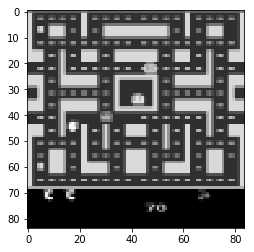

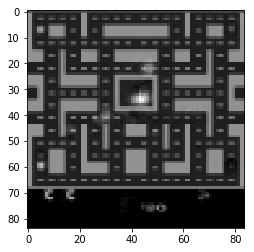

NOOP


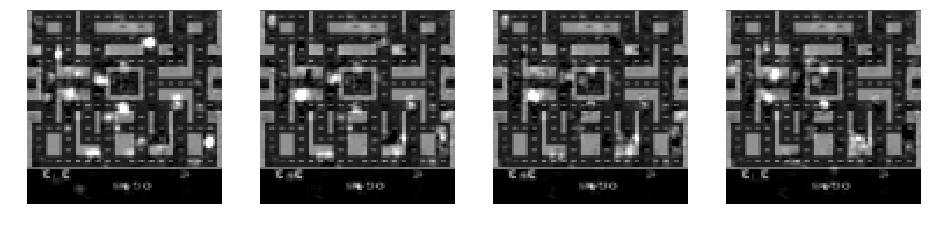

UP


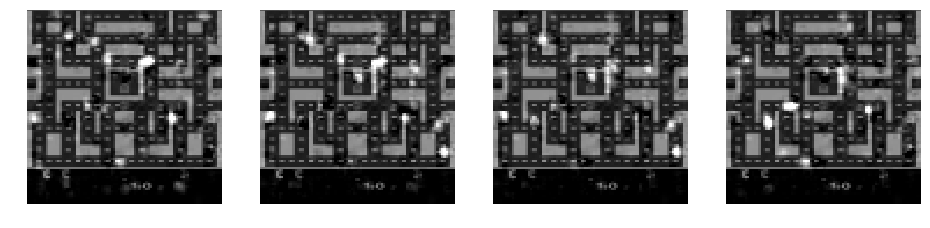

RIGHT


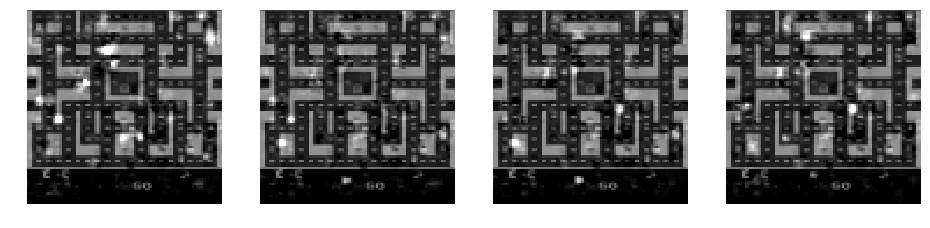

LEFT


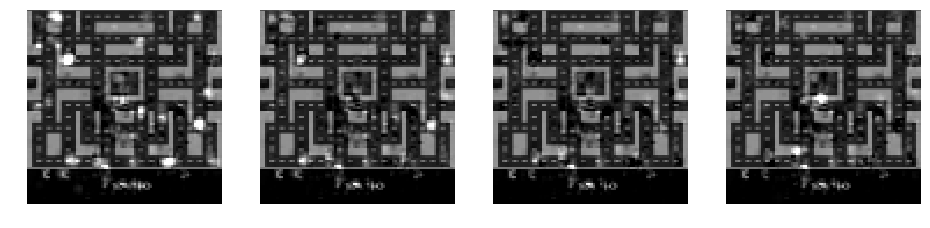

DOWN


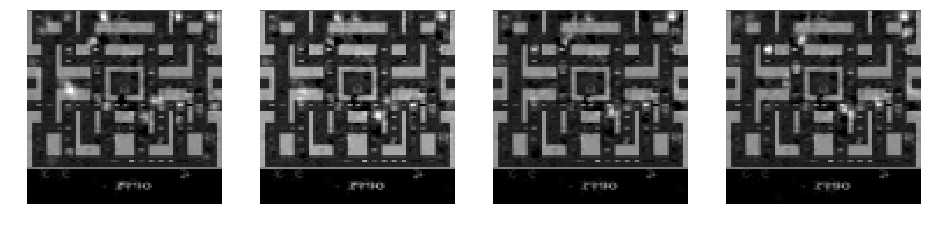

UPRIGHT


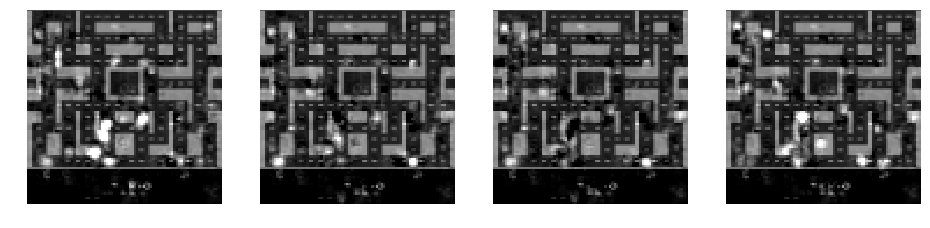

UPLEFT


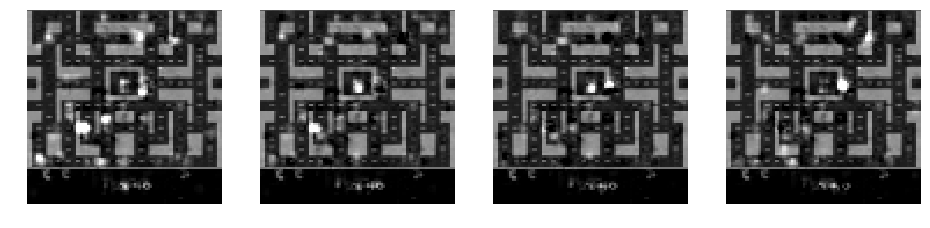

DOWNRIGHT


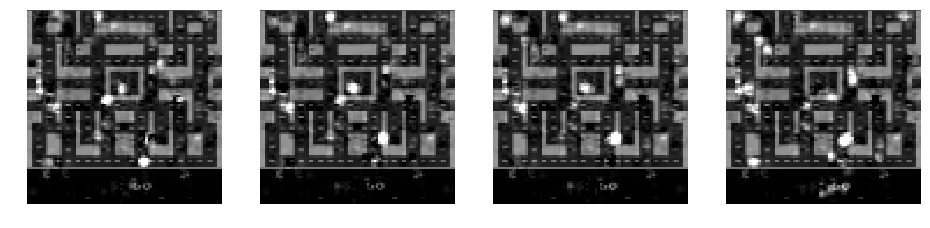

DOWNLEFT


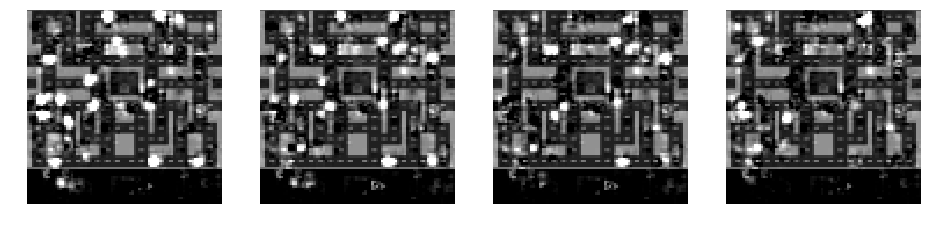

In [116]:
state = np.load('input/visualize/MsPacmanNoFrameskip-v4/89.npy')
print(meanings)

def visualize(state, net):
    # q_values, soft_keys, _ = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
    # print(q_values)

    q_values, soft_keys, output = net(Variable(FloatTensor(process_img(state)[None]), volatile=True))
        
    plt.imshow(state[:, :, 0], cmap='gray')
    plt.show()
    
    output = output.squeeze(0).permute(1, 2, 0).data.numpy()
    output = np.clip(output * 255.0 + mean_pixel_image.cpu().data.numpy(), 0, 255).astype(np.uint8)
    
    # print(embedding)
    # print(output)
    
    plt.imshow(output[:, :, 0], cmap='gray')
    plt.show()
    
#     prob_dist = 1.0 - soft_keys.data.numpy().reshape(n_action, 20)        

#     saliency = plot_saliency(net, state, act)    

#     f = plt.figure(figsize=(8,8))        
#     gs = gridspec.GridSpec(nrows=2, ncols=2)
#     # gs.update(wspace=0.0001, hspace=0.25)

#     a0 = f.add_subplot(gs[0, 0])
#     a2 = f.add_subplot(gs[0, 1])
#     a1 = f.add_subplot(gs[1, :])

#     a0.imshow(state[:, :, 3], cmap='gray')
#     a0.axis('off')

#     actions = np.arange(n_action)
#     aggs = agg_values

#     im = a1.imshow(prob_dist, cmap='gray', interpolation='nearest')

#     # We want to show all ticks...
#     a1.set_xticks(np.arange(len(aggs)))
#     a1.set_yticks(np.arange(len(actions)))
#     # ... and label them with the respective list entries
#     a1.set_xticklabels(['%.1f' % x for x in aggs])
#     a1.set_yticklabels([meanings[x] % x for x in actions])

#     # Rotate the tick labels and set their alignment.
#     plt.setp(a1.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     a1.set_title("Attention weights for different actions")

#     a2.imshow(saliency, cmap='gray')
#     a2.axis('off')    

#     f.tight_layout()
#     plt.subplots_adjust(wspace=0.025, hspace=0.025)    
#     plt.show()    
    
#     # print(net.key_matrix[8, 19, :].view(1, -1))

    for i in range(0, 9):
        print(meanings[i])
        output_from_key = net.reconstruct_key(net.key_matrix[i, 19, :].view(1, -1))
        output_from_key = output_from_key.squeeze(0).permute(1, 2, 0).data.numpy()
        output_from_key = np.clip(output_from_key * 255.0 + mean_pixel_image.cpu().data.numpy(), 0, 255).astype(np.uint8)

        f = plt.figure(figsize=(16,16))
        gs = gridspec.GridSpec(nrows=1, ncols=4)

        a0 = f.add_subplot(gs[0, 0])
        a1 = f.add_subplot(gs[0, 1])
        a2 = f.add_subplot(gs[0, 2])
        a3 = f.add_subplot(gs[0, 3])


        a0.imshow(output_from_key[:, :, 0], cmap='gray')
        a0.axis('off')    
        a1.imshow(output_from_key[:, :, 1], cmap='gray')
        a1.axis('off')    
        a2.imshow(output_from_key[:, :, 2], cmap='gray')
        a2.axis('off')    
        a3.imshow(output_from_key[:, :, 3], cmap='gray')
        a3.axis('off')
        plt.show()  
    


visualize(state, net)
    



In [110]:
print(net.key_matrix.shape)

torch.Size([9, 20, 256])
